# The Library

In [27]:
import pandas as pd
import seaborn as sb
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
import re
from sklearn import discriminant_analysis
from sklearn.preprocessing import LabelEncoder
from fitter import Fitter, get_common_distributions, get_distributions
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from factor_analyzer.factor_analyzer import calculate_kmo, calculate_bartlett_sphericity
import sklearn
from sklearn.metrics import r2_score, mean_squared_error


In [29]:
import warnings
warnings.filterwarnings('ignore')

# The Necessary Files

In [30]:
current_dir = os.getcwd()
folder = '/data/results_international/'
result_file = 'adj_final_results.csv'
rubicology_file = 'all_games_RWC2023_fixed.csv'

# Expected score gap by elo gap/ relation between elo and score against or for?

In [31]:
result_df = pd.read_csv(current_dir+folder+result_file)
result_df['date'] = pd.to_datetime(result_df['date'])
result_df['point_gap'] = result_df.apply(lambda row: abs(row['Score A']-row['Score B']) , axis=1)
result_df.head(2)

,Unnamed: 0,date,Team A,Team B,Score A,Score B,Tourn,Venue,City,Neut.,Country,elo_home,elo_away,proba_home_win,elo_gap,outcome,point_gap
0,0,1882-12-16,Wales,England,0,2,Home_Nations_Championship,NaN,Swansea,True,NaN,1000.0,1000.00000,0.500000,0.00000,0.0,2
1,1,1883-01-08,Scotland,Wales,3,1,Home_Nations_Championship,NaN,Edinburgh,True,NaN,1000.0,982.97151,0.524486,17.02849,1.0,2


In [32]:
#relationship between point gap and elo gap
result_positive_elo_gap = result_df
result_positive_elo_gap["elo_gap"] = result_positive_elo_gap["elo_gap"].abs()

[Text(0, 0.5, 'Point Gap'), Text(0.5, 0, 'Elo Gap')]

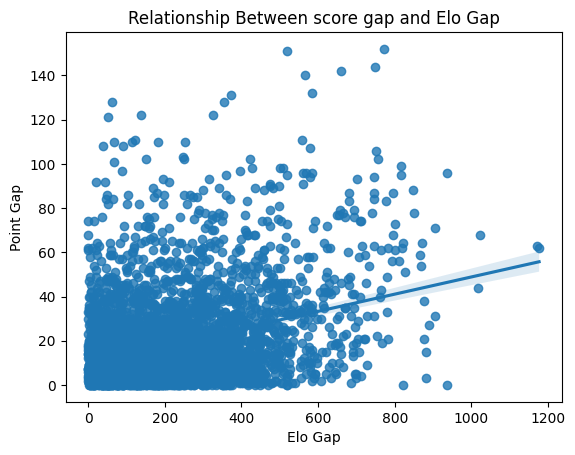

In [33]:
elo_gap_ax = sns.regplot(data=result_positive_elo_gap, y="point_gap", x="elo_gap")
elo_gap_ax.set(title='Relationship Between score gap and Elo Gap')
elo_gap_ax.set(ylabel='Point Gap', xlabel='Elo Gap')

[11.22398114  1.00385823  0.51257302]


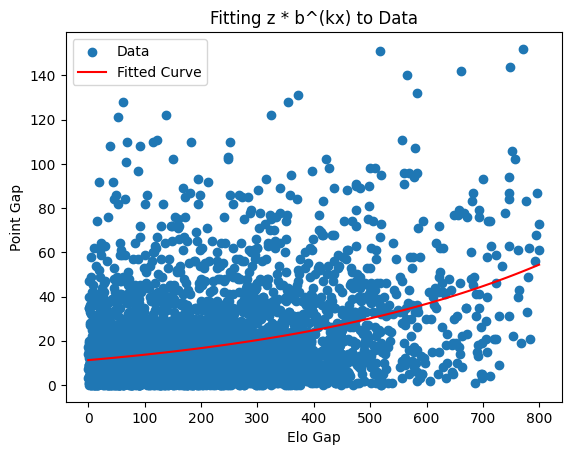

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

grouped_result = result_positive_elo_gap.groupby('elo_gap')['point_gap'].median().reset_index()
result_positive_elo_gap["elo_gap"] = (result_positive_elo_gap["elo_gap"] /10).round(0)*10
X = np.array(grouped_result['elo_gap']).reshape(-1, 1)
Y = np.array(grouped_result['point_gap']).reshape(-1, 1)


grouped_result = grouped_result[grouped_result['elo_gap']<800]
# Assuming result_positive_elo_gap contains your data
x_data = grouped_result['elo_gap']
y_data = grouped_result['point_gap']

# Define the function
def custom_func(x, z, b, k):
    return z * (b ** (k * x))

# Fit the curve to the data
popt, pcov = curve_fit(custom_func, x_data, y_data)
print(popt)
# Get the optimized parameters
z_opt, b_opt, k_opt = popt

# Generate points for the curve
x_curve = np.linspace(min(x_data), max(x_data), 100)
y_curve = custom_func(x_curve, z_opt, b_opt, k_opt)

# Plot the data and the fitted curve
plt.scatter(x_data, y_data, label='Data')
plt.plot(x_curve, y_curve, 'r-', label='Fitted Curve')
plt.xlabel('Elo Gap')
plt.ylabel('Point Gap')
plt.title('Fitting z * b^(kx) to Data')
plt.legend()
plt.show()

In [35]:
excluded_tournaments = ['Rugby_World_Cup', 'Rugby_World_Cup_Pool_A', 'Rugby_World_Cup_Pool_B', 'Rugby_World_Cup_Pool_C', 'Rugby_World_Cup_Pool_D']


# Filter train data
result_positive_elo_gap_train = result_positive_elo_gap[
    (~result_positive_elo_gap['Tourn'].isin(excluded_tournaments)) & 
    (result_positive_elo_gap['date'].dt.year != 2023)
]

# Filter test data
result_positive_elo_gap_test = result_positive_elo_gap[
    (result_positive_elo_gap['Tourn'].isin(excluded_tournaments)) & 
    (result_positive_elo_gap['date'].dt.year == 2023) 
]
#estimate point gap
X = np.array(result_positive_elo_gap_train['elo_gap']).reshape(-1,1)
y= np.array(result_positive_elo_gap_train['point_gap']).reshape(-1,1)
X_test = np.array(result_positive_elo_gap_test['elo_gap']).reshape(-1,1)
Y_test = np.array(result_positive_elo_gap_test['point_gap']).reshape(-1,1)

<Axes: xlabel='elo_gap', ylabel='Count'>

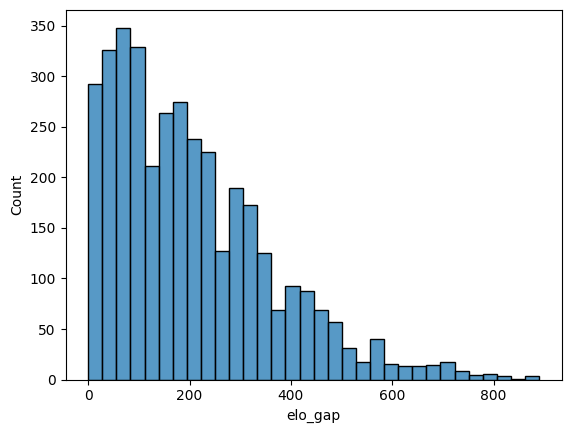

In [36]:
#plot the elo gaps
sns.histplot(data=result_positive_elo_gap_train, x='elo_gap')

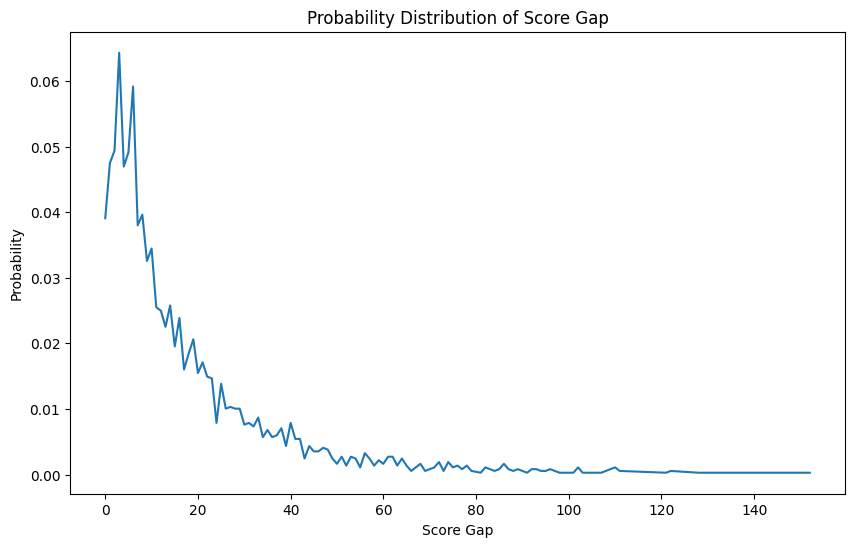

In [37]:
# Group by score gaps, then count occurrences
score_gap_counts_total = result_positive_elo_gap_train.groupby('point_gap').size().reset_index(name='Count')

# Calculate the total count of score gaps
total_gap_counts = score_gap_counts_total['Count'].sum()

# Calculate the probability of each score gap happening
score_gap_counts_total['Probability'] = score_gap_counts_total['Count'] / total_gap_counts

# Plot the line plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=score_gap_counts_total, x='point_gap', y='Probability')
plt.xlabel('Score Gap')
plt.ylabel('Probability')
plt.title('Probability Distribution of Score Gap')
plt.show()

Text(0.5, 0, 'Score Gap')

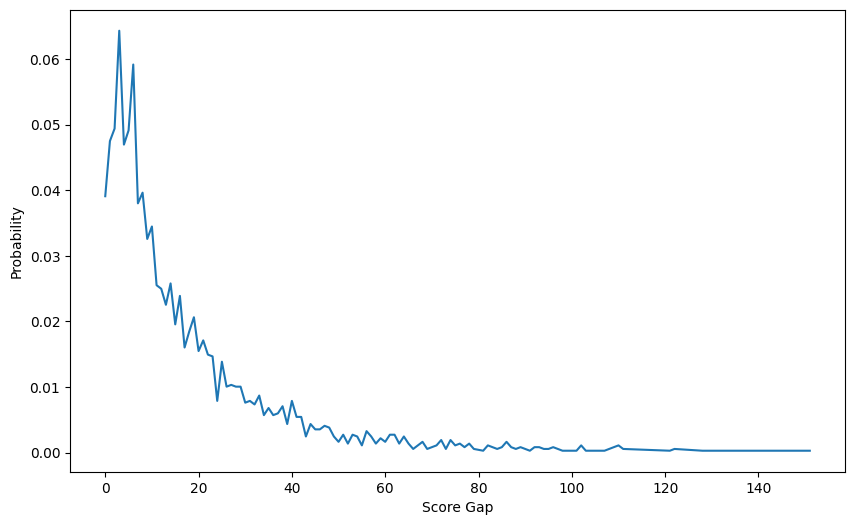

In [38]:
#do the same, but only take the score that represent 95% of the possibilities
# Calculate the cumulative probability
topN = 1

score_gap_counts_total['Cumulative Probability'] = score_gap_counts_total['Probability'].cumsum()
# Filter the DataFrame to include only the scores representing the top 95% of probabilities
top_N_percent_scores = score_gap_counts_total[score_gap_counts_total['Cumulative Probability'] <= topN]
# Plot the line plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=top_N_percent_scores, x='point_gap', y='Probability')
plt.xlabel('Score Gap')

from fitter import Fitter, get_common_distributions, get_distributions

f = Fitter(result_positive_elo_gap_train['point_gap'])
f.fit()
f.summary()

print(f.get_best(method = 'sumsquare_error'))
f.fitted_param["johnsonsb"]

<Axes: xlabel='Score', ylabel='Count'>

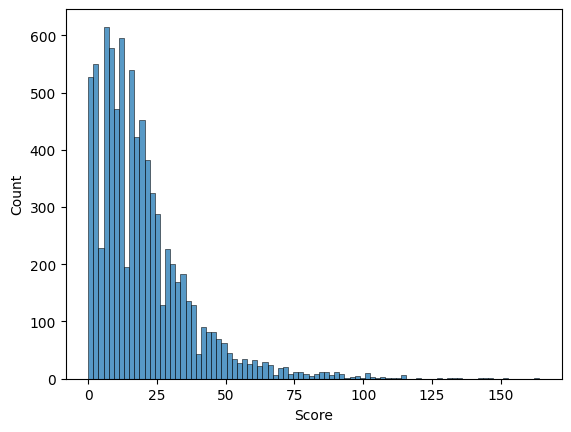

In [39]:
#for each team, is there a lot of variation in score
scores_team_a= result_positive_elo_gap[['Team A','Score A', 'elo_home']].rename(columns={'Team A':'Team', 'Score A': 'Score', 'elo_home':'Elo'})
scores_team_b= result_positive_elo_gap[['Team B','Score B', 'elo_away']].rename(columns={'Team B':'Team', 'Score B': 'Score', 'elo_away':'Elo'})
all_scores = pd.concat([scores_team_a,scores_team_b])[['Team', 'Score', 'Elo']]
sns.histplot(data=all_scores, x='Score')

In [40]:
predicted_y = [custom_func(x, z_opt, b_opt, k_opt ) for x in X]
predicted_y_test =[custom_func(x, z_opt, b_opt, k_opt ) for x in X_test]

rmse_train_linear = np.sqrt(np.mean((predicted_y - y)**2))
rmse_test_linear = np.sqrt(np.mean((predicted_y_test - Y_test)**2))


print(f'rmse train linear: {rmse_train_linear}')
print(f'rmse test linear: {rmse_test_linear}')


result_positive_elo_gap_train['predicted_gap'] = predicted_y
result_positive_elo_gap_test['predicted_gap'] = predicted_y_test

rmse train linear: 18.6753527096679
rmse test linear: 17.15837272161071


In [41]:
result_positive_elo_gap_test

,Unnamed: 0,date,Team A,Team B,Score A,Score B,Tourn,Venue,City,Neut.,Country,elo_home,elo_away,proba_home_win,elo_gap,outcome,point_gap,predicted_gap
3961,3961,2023-09-08,France,New Zealand,27,13,Rugby_World_Cup_Pool_A,Stade de France,Saint-Denis,True,NaN,1663.837464,1867.245237,0.236691,200.0,1.0,14,[16.656768022835934]
3962,3962,2023-09-09,Australia,Georgia,35,15,Rugby_World_Cup_Pool_C,Stade de France,Saint-Denis,True,NaN,1475.604812,1445.090649,0.543801,30.0,1.0,20,[11.908676547119413]
3963,3963,2023-09-09,England,Argentina,27,10,Rugby_World_Cup_Pool_D,Stade Vélodrome,Marseille,True,NaN,1584.721703,1470.883254,0.658205,110.0,1.0,17,[13.945722631865642]
3964,3964,2023-09-09,Italy,Namibia,52,8,Rugby_World_Cup_Pool_A,Stade Geoffroy-Guichard,Saint-Étienne,True,NaN,1100.789263,803.235925,0.847206,300.0,1.0,44,[20.291429433066753]
3965,3965,2023-09-09,Ireland,Romania,82,8,Rugby_World_Cup_Pool_B,Nouveau Stade de Bordeaux,Bordeaux,True,NaN,1769.271460,1061.057257,0.983321,710.0,1.0,74,[45.57980376998524]
3966,3966,2023-09-10,Wales,Fiji,32,26,Rugby_World_Cup_Pool_C,Nouveau Stade de Bordeaux,Bordeaux,True,NaN,1468.536433,1403.992020,0.591833,60.0,1.0,6,[12.635140364783748]
3967,3967,2023-09-10,Japan,Chile,42,12,Rugby_World_Cup_Pool_D,Stadium de Toulouse,Toulouse,True,NaN,1328.868770,730.646243,0.969041,600.0,1.0,30,[36.6841411662559]
3968,3968,2023-09-10,South Africa,Scotland,18,3,Rugby_World_Cup_Pool_B,Stade Vélodrome,Marseille,True,NaN,1741.154820,1431.484146,0.856019,310.0,1.0,15,[20.6959245544882]
3969,3969,2023-09-14,France,Uruguay,27,12,Rugby_World_Cup_Pool_A,Stade Pierre-Mauroy,Villeneuve-d'Ascq,True,NaN,1722.493700,1032.485255,0.981513,690.0,1.0,15,[43.81553008426256]
3970,3970,2023-09-15,New Zealand,Namibia,71,3,Rugby_World_Cup_Pool_A,Stadium de Toulouse,Toulouse,True,NaN,1808.589001,787.353393,0.997209,1020.0,1.0,68,[84.04470469162837]


# First exploration: Any upsets?

In [42]:
#Conditions on wins
condition_1 = result_positive_elo_gap_test['elo_gap']>100
condition_2 = (result_positive_elo_gap_test['proba_home_win']<0.5) & (result_positive_elo_gap_test['outcome']>0)
condition_3 = (result_positive_elo_gap_test['proba_home_win']>0.5) & (result_positive_elo_gap_test['outcome']<1)
#conditions on score 
condition_4 = result_positive_elo_gap_test['point_gap'] <result_positive_elo_gap_test['predicted_gap']-7
## we will look at score gap smaller than expectd
upsets = result_positive_elo_gap_test[((condition_1) & (condition_2 |condition_3 )) | (condition_1 & condition_4 ) ]
upsets.head(5)

,Unnamed: 0,date,Team A,Team B,Score A,Score B,Tourn,Venue,City,Neut.,Country,elo_home,elo_away,proba_home_win,elo_gap,outcome,point_gap,predicted_gap
3961,3961,2023-09-08,France,New Zealand,27,13,Rugby_World_Cup_Pool_A,Stade de France,Saint-Denis,True,NaN,1663.837464,1867.245237,0.236691,200.0,1.0,14,[16.656768022835934]
3969,3969,2023-09-14,France,Uruguay,27,12,Rugby_World_Cup_Pool_A,Stade Pierre-Mauroy,Villeneuve-d'Ascq,True,NaN,1722.493700,1032.485255,0.981513,690.0,1.0,15,[43.81553008426256]
3970,3970,2023-09-15,New Zealand,Namibia,71,3,Rugby_World_Cup_Pool_A,Stadium de Toulouse,Toulouse,True,NaN,1808.589001,787.353393,0.997209,1020.0,1.0,68,[84.04470469162837]
3971,3971,2023-09-16,Ireland,Tonga,59,16,Rugby_World_Cup_Pool_B,Stade de la Beaujoire,Nantes,True,NaN,1770.960147,1007.729390,0.987794,760.0,1.0,43,[50.307577331132975]
3976,3976,2023-09-17,Australia,Fiji,15,22,Rugby_World_Cup_Pool_C,Stade Geoffroy-Guichard,Saint-Étienne,True,NaN,1518.071955,1380.071845,0.688774,140.0,0.0,7,[14.796452170378771]


In [56]:
relative_df_ratio = create_relative_ratio_df(split_df)
relative_df_ratio.reset_index(inplace=True, drop=True)
#ealtive_transpose_ratio = relative_df_ratio.transpose().reset_index(drop=True)
relative_df_ratio.head(5)

,Date,Game ID,Team,Score,Possession - Overall,Possession - 1st half,Possession - 2nd half,Tries,Conversions,Penalties,...,Scrums Total,Penalties Conceded Own Half,Penalties Conceded Opp Half,Yellow Cards,Red Cards,% Rucks Successful,% Goal kicks Successful,% Scrums Successful,% Tackle Successful,Outcome
0,8-Sep-2023,87834,France,0.675000,0.49,0.44,0.53,0.500000,1.0,0.833333,...,0.416667,0.222222,0.285714,0.0,0.0,0.932203,0.666667,0.800000,0.808383,1.0
1,8-Sep-2023,87834,New Zealand,0.325000,0.51,0.56,0.47,0.500000,0.0,0.166667,...,0.583333,0.777778,0.714286,1.0,0.0,0.937500,0.333333,0.714286,0.853211,0.0
2,9-Sep-2023,87835,Namibia,0.133333,0.48,0.53,0.44,0.125000,0.0,0.500000,...,0.500000,0.454545,0.727273,1.0,0.0,0.962963,0.333333,1.000000,0.722973,0.0
3,9-Sep-2023,87835,Italy,0.866667,0.52,0.47,0.56,0.875000,1.0,0.500000,...,0.500000,0.545455,0.272727,0.0,0.0,0.935484,1.000000,1.000000,0.914894,1.0
4,9-Sep-2023,87836,Ireland,0.911111,0.67,0.57,0.76,0.923077,1.0,0.000000,...,0.500000,0.222222,0.375000,0.0,0.0,0.978495,0.916667,0.888889,0.853333,1.0


In [ ]:
relative_df = create_relative_diff_df(split_df)
realtive_transpose = relative_df.transpose().reset_index(drop=True)
realtive_transpose.head(2)

In [ ]:
realtive_transpose.shape

# Next, explore what a mean performance is and for each metric, define a strength scalr or weakness depending on the rank 

In [ ]:
#next, do max normalisation for each column, to have each value between 0 and 1. we<ll have percentages in function of the best performance
columns_to_apply = relative_df_ratio_average.columns.drop('Team')
relative_df_ratio_average[columns_to_apply] = relative_df_ratio_average[columns_to_apply].apply(lambda col: col / max(col))

# PCA in itself

# look at correlation between variable 

# Sphericyty With Barlett test

In [ ]:
pca = decomposition.PCA()
pca.fit(X)
transformed = pca.transform(X)

 A PCA on correlations was calculated to identify the principal components accounting for the most relevant variance, which was dictated by those possessing eigenvalues > 1.0. From there, a variable loading matrix with a VariMax rotation was generated to identify variables in the principal components with an individual loading value ≥ 0.70. Next, a multinominal logistic regression was constructed using athlete POS (Guards, Forwards, Centers) as the response variable, and the most relevant PCA variables as predictors. 

In [ ]:
eigenvalues = pca.explained_variance_
eigenvectors = pca.components_

In [ ]:
cumulative_sum = np.cumsum(pca.explained_variance_ratio_, axis=0)
fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(1, 1, 1)
ax.plot(cumulative_sum)
ax.set_title('Cumulative Sum of PCA Explained Variance')
ax.set_ylabel('Explained Variance')
ax.set_xlabel('Number of Components')

In [ ]:
def top_N(cumulative_sum, percentage):
    topN = np.where(cumulative_sum > percentage)[0][0]
    print(f'{percentage*100}% in ' + '%d' % (topN+1) + ' components')
    return topN

top80 = top_N(cumulative_sum, 0.80)
transformed_80 = transformed[:,0:top80]

In [ ]:
lda = discriminant_analysis.LinearDiscriminantAnalysis()
lda.fit(np.array(transformed_80), np.array(y_encoded ))
transformed = lda.transform(transformed_80)

# measure of sampling adequacy (MSA): Kaiser-Meyer-Olkin measure (KMO)

In [ ]:
#split the variable 
plt.figure()
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
          '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5',
          '#c49c94', '#f7b6d2', '#c7c7c7', '#dbdb8d', '#9edae5']
lw = 2

for color, i, target_name in zip(colors, range(20), target_names):
    plt.scatter(
        transformed[y_encoded == i, 0], transformed[y_encoded == i, 1], color=color, alpha=0.8, lw=lw, label=target_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA of IRIS dataset")
plt.show()

In [ ]:
#test prediction for each each team
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y_encoded,test_size=0.25)

from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.01,
max_depth=10, random_state=69).fit(X_train, y_train)
clf.score(X_test, y_test)

In [ ]:
# in upset, what kpi is most important?

In [ ]:
#flip the df so hat the winning team is alway A
df = wc_odds_df


def swap_columns(row):
    if row['Score B'] > row['Score A']:
         # Swap 'Team A' and 'Team B'
        row['Team A'], row['Team B'] = row['Team B'], row['Team A']

        # Swap 'Odds A' and 'Odds B'
        row['Odds A'], row['Odds B'] = row['Odds B'], row['Odds A']

        # Swap 'Score A' and 'Score B'
        row['Score A'], row['Score B'] = row['Score B'], row['Score A']
    return row

df = df.apply(lambda row: swap_columns(row), axis=1)
df['Proba_win'] = 1/df['Odds A'] 
df['Proba_loss'] = 1/df['Odds B'] 

In [ ]:
df.head(2)

# What is the relationship between proba of winning and score gap?

In [ ]:
sb.scatterplot(data=df, x='Proba_win', y='score_gap')

In [ ]:
# any relation ship?
result_positive_elo_gap_test.shape

# How unbalance is the dataset

In [ ]:
#first, rearrange the data to have the team 
select_df = df[['Proba_win', 'Proba_loss','Year']]
select_df['Max_proba']= select_df[['Proba_win', 'Proba_loss']].max(axis=1)
#do the same for home dataset
select_proba_house = result_positive_elo_gap_test[['proba_home_win', 'date', 'Tourn', 'outcome']]
select_proba_house['Max_proba'] = select_proba_house.apply(lambda row: max(row['proba_home_win'], 1-row['proba_home_win']), axis=1)
# Plot the KDE plot using Max_Proba
plot_bet = sns.kdeplot(data=select_df,x='Max_proba', fill=True, hue='Year', common_norm=True)
# overall
plot_bet.set(title='Probability Distribution of Winning Proabilty RWC 2023-Booky Odds')


In [ ]:
plot_me = sns.kdeplot(data=select_proba_house,x='Max_proba', fill=True, common_norm=True)
plot_me = sns.kdeplot(data=select_df[select_df['Year']==2023],x='Max_proba', fill=True, hue='Year', common_norm=True)
plot_me.set(title='Probability Distribution of Winning Proabilty RWC 2023')

In [ ]:
#on my predictions:
select_proba_house = result_positive_elo_gap[['proba_home_win', 'date', 'Tourn', 'outcome']]

#first: proba of draw
proba_draw = select_proba_house[select_proba_house['outcome']==0.5]
odds_draw = proba_draw.shape[0]/ result_positive_elo_gap.shape[0]
print(f'the probability of drawing a game is {odds_draw:.2}')
#plot  = sb.kdeplot(data=result_positive_elo_gap_test, x='Proba_win', fill=True, hue='Year')
#plot.set(title='Probability Distribution of Winning Proabbilty-Booky Odds')

In [ ]:
#look at the proba of wining
df[(df['Proba_win']<0.4 )& (df['Year']==2023)]

In [ ]:
booky_advantage = df['sum'].mean()-1
print(f'The bookkeeper margin is {booky_advantage : 2f}%')

In [ ]:
df[(df['Proba_win']>0.8 )& (df['Year']==2023)&(df['score_gap']<=7)]

# That's 8 games to work with

In [ ]:
#select the game from the main df
game_IDs = [87874,87873, 87848,87879,87869,87862,87853]
relative_df_ratio['upset'] =  relative_df_ratio['Game ID'].apply(lambda x : 1 if x in (game_IDs) else 0)
#upset_df_teams = relative_df_ratio[relative_df_ratio['Game ID'].isin(game_IDs)]

In [ ]:
realtive_transpose.columns

# Proper Analysis

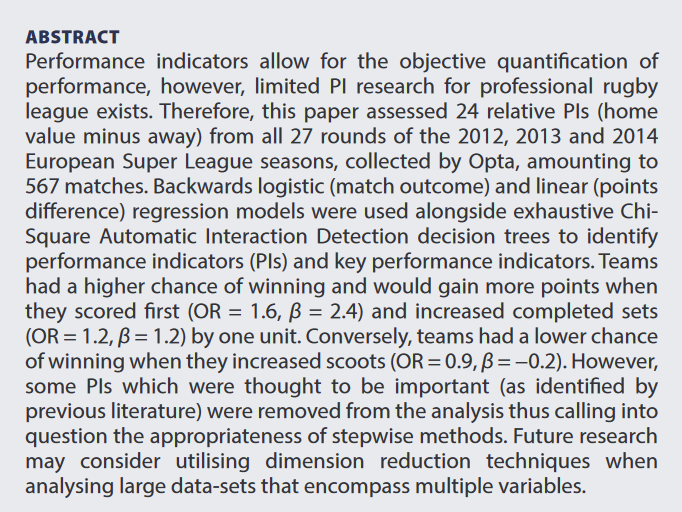

stead, one should use variable inflation factor or VIF, which can be computed for each regressor by fitting an OLS model that has the regressor in question as a target variable and all other regressors as features.  If a strong relationship exists between the target (e.g. regressor in question) and at least one other regressor, the VIF will be high.  What is high?  Textbooks usually suggest 5 or 10 as a cutoff value above which the VIF score suggests the presence of multicollinearity. So which one, 5 or 10? If the dataset is very large with a lot of features, a VIF cutoff of 10 is acceptable.  Smaller datasets require a more conservative approach where the VIF cutoff may needed to be dropped to 5.  I have seen people using an even lower cutoff threshold, and the purpose of the analysis should dictate which threshold to use. 

#exlude draws
#indicator of form: 5 games before, difference in score , also include elo
#use frequency: home vs away
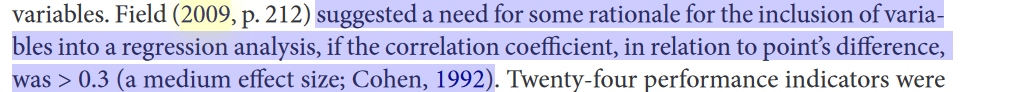

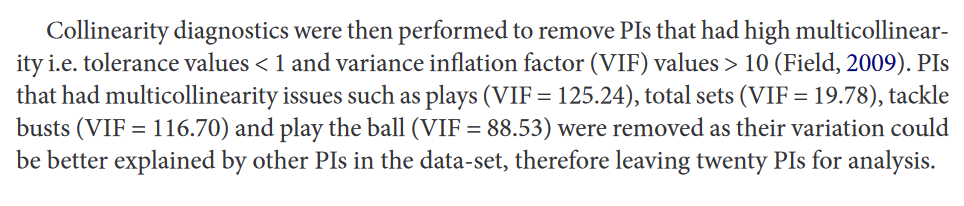

# Backward logistic regression based on likelyhood ratio

## The score

### define train and test for both study

In [82]:
def do_score_analyses(df, train_split=0.4):
    variables_to_remove = ['Game ID', 'Date', 'Team','Outcome', 'Score']
    df_removed = df[variables_to_remove]
    y=np.array(df_removed['Outcome'])
    score = np.array(df_removed['Score'])
    #score = np.array(data_corr_multi['Score'])
    y=[int(i)for i in y]
    x_corr_multi=df.drop(columns=variables_to_remove)
    X_corr_multi=np.array(x_corr_multi)
    X_train, X_test, Y_train, Y_test = train_test_split(X_corr_multi, score,test_size = train_split, random_state = 5)
    #fine tune alpha
    test_alpha = [0.0001, 0.001, 0.01, 0.1,1]
    best_alpha = 0
    best_rmse_sm = 1000 
    best_model =None
    for alpha in test_alpha:
        ridge_model_sm = sm.OLS(Y_train, X_train)
        res = ridge_model_sm .fit_regularized(alpha=alpha, L1_wt=0.0, profile_scale=False)
        rmse_sm = np.sqrt(mean_squared_error(Y_test, res.predict(X_test)))
        if rmse_sm < best_rmse_sm:
            best_rmse_sm = rmse_sm 
            best_alpha = alpha
            best_model = res
    
    r_2_sm = r2_score(Y_train, res.predict(X_train))
    print(r_2_sm)
    print(best_rmse_sm, best_alpha)
    params = best_model.params
    df['predicted_score'] = best_model.predict(X_corr_multi)
    #resutl_df_score = pd.DataFrame({'Feature'  :x_corr_multi.columns, 'Params':params })
    #resutl_df_score.sort_values(by='Params')
    df['predicted_gap'] = abs(df['Score'] - df['predicted_score'] )
    return df

score_pred = do_score_analyses(data_corr_multi)
score_pred.sort_values(by='predicted_gap')

NameError: name 'data_corr_multi' is not defined

# Linear Regression

In [111]:
from sklearn.metrics import r2_score, mean_squared_error

variables_to_remove = ['Game ID', 'Date', 'Team','Outcome', 'Score']
y=np.array(data_corr_multi['Outcome'])
score = np.array(data_corr_multi['Score'])
#score = np.array(data_corr_multi['Score'])
y=[int(i)for i in y]
x_corr_multi=data_corr_multi.drop(columns=variables_to_remove)
X_corr_multi=np.array(x_corr_multi)

NameError: name 'data_corr_multi' is not defined

## Do backward Stepwise 

### Get Difference between group with t test

### Do stepwise

In [ ]:
res= do_stat_logit(x_corr_multi,y)
create_summary_log(res, 0.9)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.46523003267351976
            Iterations: 55
            Function evaluations: 55
            Gradient evaluations: 55
                       Features    params   pvalues
0         Possession - 1st half  0.204661  0.736255
1                        Metres  1.130587  0.298277
2                  Clean breaks -0.138659  0.884734
3                        Passes -1.347809  0.160342
4                      Offloads  0.313450  0.628275
5                 Turnovers won  0.356156  0.572745
6               Kicks from Hand  1.041711  0.140034
7           Lineouts Successful  0.382657  0.506889
8   Penalties Conceded Opp Half -1.080106  0.095438
9            % Rucks Successful -0.559086  0.427566
10      % Goal kicks Successful  0.322910  0.486420
11          % Tackle Successful -0.049957  0.935947


,Features,params,pvalues,Odds,Percent
0,Possession - 1st half,0.204661,0.736255,1.227110,22.710960
1,Metres,1.130587,0.298277,3.097475,209.747486
2,Clean breaks,-0.138659,0.884734,0.870525,-12.947517
3,Passes,-1.347809,0.160342,0.259809,-74.019112
4,Offloads,0.313450,0.628275,1.368137,36.813662
5,Turnovers won,0.356156,0.572745,1.427830,42.782979
6,Kicks from Hand,1.041711,0.140034,2.834063,183.406258
7,Lineouts Successful,0.382657,0.506889,1.466175,46.617454
8,Penalties Conceded Opp Half,-1.080106,0.095438,0.339560,-66.044034
9,% Rucks Successful,-0.559086,0.427566,0.571731,-42.826864


In [963]:
# analyse with cor only
variables_to_remove = ['Game ID', 'Date', 'Team','Outcome', 'Score']
y=np.array(data_corr['Outcome'])
y=[int(i)for i in y]
x_corr_multi=data_corr.drop(columns=variables_to_remove)
#do reg
res= do_stat_logit(x_corr_multi,y)
create_summary_log(res, 0.9)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.3468329050397999
            Iterations: 119
            Function evaluations: 120
            Gradient evaluations: 119
                       Features    params   pvalues
0         Possession - 1st half  1.531244  0.038378
1                         Tries  7.982462  0.015726
2                   Conversions -4.933435  0.134518
3                        Metres  1.200675  0.545682
4              Defenders Beaten  0.663318  0.000000
5                  Clean breaks -2.870088  0.002221
6             Gain line Carries -5.566581  0.000000
7                        Passes  0.040543  0.969912
8                      Offloads -0.405695  0.637227
9                 Turnovers won -0.569333  0.505877
10              Kicks from Hand -1.200825  0.245119
11               Tackles Missed -0.663318  0.000000
12        Goal Kicks Successful  6.994114  0.178049
13         Goal Kicks Attempted -2.708784  0.546083
14     

,Features,params,pvalues,Odds,Percent
0,Possession - 1st half,1.531244,0.038378,4.623925,362.392490
1,Tries,7.982462,0.015726,2929.133678,292813.367777
2,Metres,1.200675,0.545682,3.322359,232.235929
3,Defenders Beaten,0.663318,0.000000,1.941223,94.122320
4,Goal Kicks Successful,6.994114,0.178049,1090.196972,108919.697175


# Combine with pca, do analysis on single factors following a pca and selection of components with eigenvalue over 1

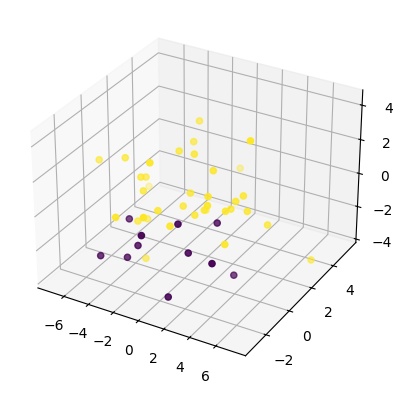

In [100]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X_r_selected[:,0], X_r_selected[:,1], X_r_selected[:,2], c=y, cmap='viridis')
plt.show()

In [180]:
reconstructed_1 = X_r_selected.dot(pca.components_) + pca.mean_
X_r_selected_df = pd.DataFrame(data=X_r_selected, columns=pc_feature)
print('\nError: %f' % (np.square(X_scaled - reconstructed_1)).mean(axis=None))
#prepare reg with the lower dimensions data, no constant because regularised
model = do_stat_logit(X_r_selected_df,y)
result_df = create_summary_log(model, target= 1)


Error: 0.151464
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.49512970288199826
            Iterations: 23
            Function evaluations: 24
            Gradient evaluations: 23


logit_result = result_df_glm.sort_values(by='pvalues', ascending=False) 
print(logit_result )
data_stepwise_log = X_r_selected_df 
pvalue = list(logit_result .pvalues.values)
params= list(logit_result .Features.values)
best_accuracy = 0
i=0
best_model_log= None
y = np.array(data['Outcome'])
while pvalue[i]>0.05:
    selected_df = data_stepwise_log.drop(columns=params[i])
    columns = selected_df.columns
    X_train, X_test, Y_train, Y_test = train_test_split(selected_df , y, test_size = 0.40, random_state = 6)
 
    model = sm.GLM( Y_train, X_train, family=sm.families.Binomial()).fit()
    Y_pred_test = model.predict(X_test)
    Y_pred_test = [1 if y >0.5 else 0 for y in Y_pred_test]
    Y_pred_train = model.predict(X_train)
    accuracy = sklearn.metrics.accuracy_score(Y_test, Y_pred_test)

    print(accuracy, X_train.shape)
    if accuracy >= best_accuracy:
        best_accuracy = accuracy 
        best_model = model
        data_stepwise_log  = selected_df
        best_model_log = model
    i+=1

print(best_model_log.summary())

## Linear Regression 

In [113]:
logit_result = result_df_glm.sort_values(by='pvalues', ascending=False) 
print(logit_result )
data_stepwise_corr = X_r_selected_df 
pvalue = list(logit_result.pvalues.values)
params= list(logit_result.Features.values)
best_rmse_sm = float('inf')
i=0
best_model_corr= None
y=data.Score
while pvalue[i]>0.05:
    selected_df = data_stepwise_corr.drop(columns=params[i])
    columns = selected_df.columns
    X_train, X_test, Y_train, Y_test = train_test_split(selected_df , y, test_size = 0.40, random_state = 6)
 
    model = sm.OLS(Y_train, X_train).fit()
    Y_pred_test = model.predict(X_test)
    Y_pred_train = model.predict(X_train)
    rmse_sm = np.sqrt(mean_squared_error(Y_test, Y_pred_test ))

    print(rmse_sm, X_train.shape)
    if rmse_sm <= best_rmse_sm:
        best_rmse_sm = rmse_sm 
        best_model = best_rmse_sm 
        data_stepwise_corr  = selected_df
        best_model_corr = model
    i+=1

print(best_model_corr.summary())

  Features    params   pvalues      Odds     Percent
4      PC5  0.041326  0.872069  1.042192    4.219182
7      PC8 -0.067169  0.861942  0.935037   -6.496310
6      PC7 -0.112784  0.745759  0.893344  -10.665648
0      PC1 -0.040919  0.706306  0.959907   -4.009303
3      PC4 -0.171006  0.455773  0.842816  -15.718365
5      PC6  0.301549  0.349977  1.351952   35.195202
2      PC3  0.599347  0.014719  1.820930   82.092970
1      PC2  0.735252  0.005312  2.086008  108.600846
33.5125408264833 (28, 7)
33.129293787789535 (28, 6)
32.95956035622598 (28, 5)
35.825116920837665 (28, 4)
31.129345900990224 (28, 4)
31.733618957727046 (28, 3)
                                 OLS Regression Results                                
Dep. Variable:                  Score   R-squared (uncentered):                   0.590
Model:                            OLS   Adj. R-squared (uncentered):              0.521
Method:                 Least Squares   F-statistic:                              8.618
Date:       

# look at outliers for upsets?

Linear regression to remove least important KPI
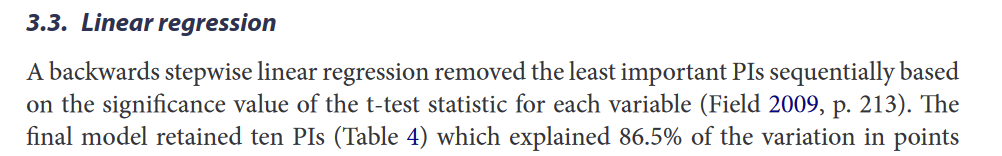

Take the significant predictor as kpi. The remove the non significant 1 by one and test rmse

In [1136]:
logit_result

,Features,params,pvalues,Odds,Percent
4,Defenders Beaten,0.014911,0.840284,1.015023,1.502277
0,Possession - 1st half,0.044488,0.679911,1.045492,4.549204
15,Yellow Cards,0.089350,0.669572,1.093464,9.346362
2,Penalties,0.090860,0.615585,1.095116,9.511602
1,Possession - 2nd half,0.045834,0.595892,1.046901,4.690104
18,% Scrums Successful,0.140621,0.585524,1.150988,15.098805
12,Lineouts Thrown,0.103816,0.471315,1.109396,10.939621
11,Lineouts Successful,0.124239,0.428760,1.132287,13.228680
19,% Tackle Successful,0.133339,0.251627,1.142637,14.263706
17,% Goal kicks Successful,0.206448,0.248457,1.229304,22.930417


,Defenders Beaten,Possession - 1st half,Yellow Cards,Penalties,Possession - 2nd half,% Scrums Successful,Lineouts Thrown,Lineouts Successful,% Tackle Successful,% Goal kicks Successful,Gain line Carries,Scrums Total,Offloads,Metres,Scrums Successful,Kicks from Hand,Tackles Made,% Rucks Successful,Turnovers won,Clean breaks
0,1.014414,0.895263,-0.649118,-0.43506,0.869629,-0.103676,1.585612,1.986716,-0.044650,-2.367332,0.350077,-2.237882,-0.382279,-0.283950,-2.262981,-0.642361,-1.617831,-0.351556,-1.358447,0.072738
1,0.162110,-0.020377,0.467196,-0.98503,0.527844,-0.154343,0.187594,0.112253,-0.452859,-0.586916,0.221178,-1.158007,0.106339,0.080295,-1.109644,-0.858489,-0.928216,-0.045814,-0.658637,-0.270942


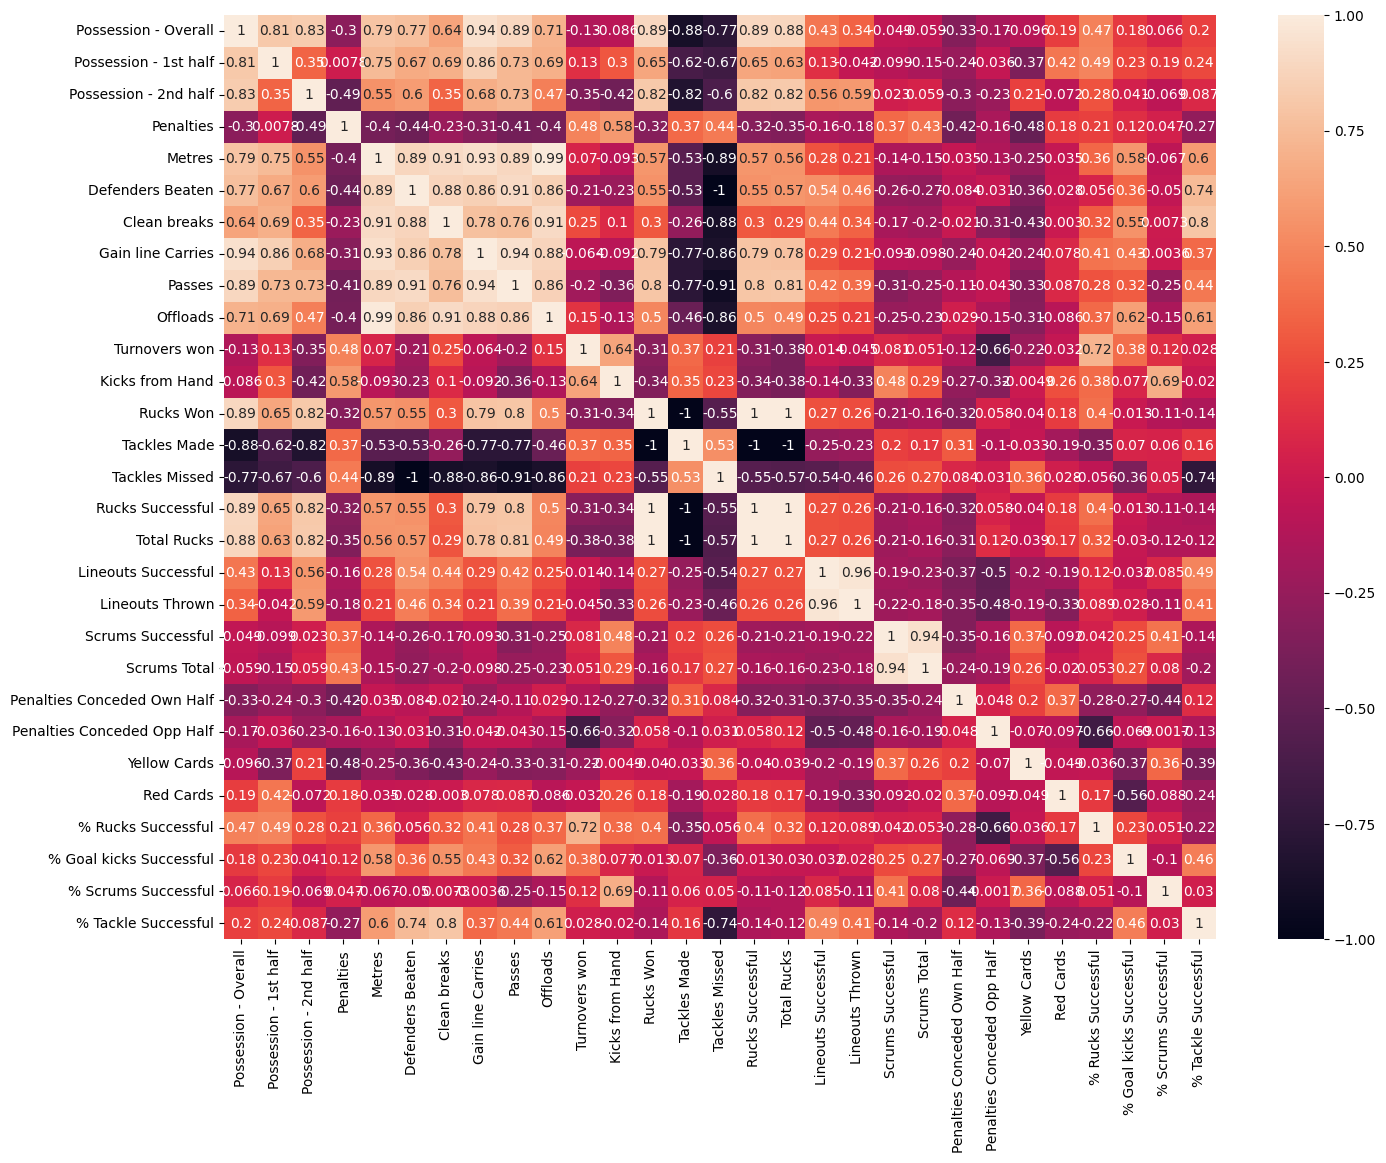

In [1178]:
data_stepwise_corr = reconstructed_1_df[logit_result.Features.values]



In [1171]:
logit_result = result_df_glm.sort_values(by='pvalues', ascending=False) 
data_stepwise_corr = reconstructed_1_df[logit_result.Features.values]
pvalue = list(logit_result.pvalues.values)
params= list(logit_result.Features.values)
best_rmse_sm = float('inf')
i=0
best_model_corr= None
y=score
while pvalue[i]>0.07:
    selected_df = data_stepwise_corr.drop(columns=params[i])
    columns = selected_df.columns
    X_train, X_test, Y_train, Y_test = train_test_split(selected_df , y, test_size = 0.30, random_state = 6)
 
    model = sm.OLS(Y_train, X_train).fit()
    Y_pred_test = model.predict(X_test)
    Y_pred_train = model.predict(X_train)
    rmse_sm = np.sqrt(mean_squared_error(Y_test, Y_pred_test ))

    print(rmse_sm, X_train.shape)
    if rmse_sm <= best_rmse_sm:
        best_rmse_sm = rmse_sm 
        best_model = res
        data_stepwise_corr  = selected_df
        best_model_corr = model
    i+=1

print(best_model_corr.summary())

0.4334088936330401 (32, 19)
0.43340889363304025 (32, 18)
0.4334088936330402 (32, 18)
0.4334088936330398 (32, 18)
0.43340889363304025 (32, 17)
0.4334088936330397 (32, 17)
0.4334088936330398 (32, 16)
0.4334088936330399 (32, 16)
0.4334088936330402 (32, 16)
0.4334088936330397 (32, 16)
0.43340889363304014 (32, 15)
0.4334088936330397 (32, 15)
0.4334088936330404 (32, 14)
0.4334088936330398 (32, 14)
0.43340889363303947 (32, 14)
0.4334088936330395 (32, 13)
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.870
Model:                            OLS   Adj. R-squared (uncentered):              0.826
Method:                 Least Squares   F-statistic:                              19.99
Date:                Sat, 25 May 2024   Prob (F-statistic):                    7.53e-09
Time:                        09:13:18   Log-Likelihood:                         -14.391
No. Observations:   

In [1111]:
corr_summary = create_summary_log(best_model_corr)
corr_summary = corr_summary.sort_values(by='params')
print(corr_summary)

                       Features    params       pvalues
0          Possession - Overall  0.060446  4.636661e-04
1         Possession - 1st half  0.099453  3.755581e-03
2         Possession - 2nd half -0.011994  6.855022e-01
3                        Metres  0.180854  8.017142e-07
4                  Clean breaks  0.180138  1.621214e-09
5                        Passes  0.040973  2.066803e-03
6                      Offloads  0.167773  2.359993e-06
7                 Turnovers won  0.161468  6.320870e-05
8               Kicks from Hand  0.138118  4.225453e-04
9                     Rucks Won -0.039806  3.032470e-02
10                 Tackles Made  0.038211  3.762261e-02
11               Tackles Missed -0.089789  2.721032e-04
12             Rucks Successful -0.039806  3.032470e-02
13                  Total Rucks -0.052346  4.559345e-03
14          Lineouts Successful -0.040676  4.866719e-01
15            Scrums Successful  0.056747  1.664337e-01
16                 Scrums Total -0.011614  8.203

# Do stepwise

# Decision Tree To analyse relationship with outcome 

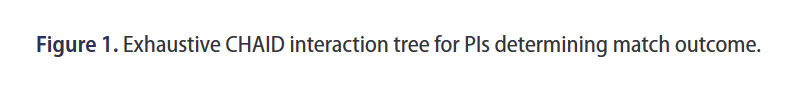

In [870]:
from sklearn.ensemble import RandomForestClassifier

In [1119]:
variables_to_remove

['Game ID',
 'Date',
 'Team',
 'Outcome',
 'Score',
 'Tries',
 'Conversions',
 'Goal Kicks Successful',
 'Goal Kicks Attempted']

Text(0.5, 25.722222222222214, 'Predicted Label')

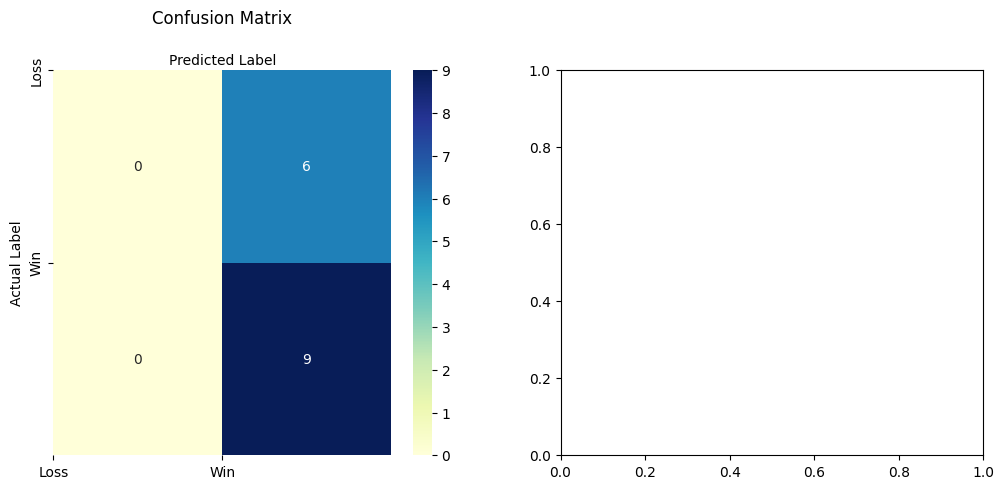

In [1133]:
estimators = [50, 100, 200, 300]
y=data['Outcome']
x = data.drop(columns=variables_to_remove)

X_train, X_test, Y_train, Y_test = train_test_split(x, y,test_size = 0.30, random_state = 5)
clf = RandomForestClassifier(max_depth=3, random_state=0)

clf.fit(X_train, Y_train)
y_pred = clf.predict(X_test)
# Plot confusion matrix

cnf_matrix = metrics.confusion_matrix(Y_test, y_pred)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
tick_marks = np.arange(len(class_names))
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g', ax=ax1)
ax1.set_xticks(tick_marks)
ax1.set_xticklabels(class_names)
ax1.set_yticks(tick_marks)
ax1.set_yticklabels(class_names)
ax1.xaxis.set_label_position("top")
ax1.set_title('Confusion Matrix', y=1.1)
ax1.set_ylabel('Actual Label')
ax1.set_xlabel('Predicted Label')